In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax, Adam
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 96% 143M/149M [00:00<00:00, 178MB/s]
100% 149M/149M [00:00<00:00, 167MB/s]


In [ ]:
import zipfile

# Descomprimir el archivo
with zipfile.ZipFile("brain-tumor-mri-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("braintumor")

print("✅ Dataset extraído correctamente")

✅ Dataset extraído correctamente


## Extracción de las rutas de las imágenes en las carpetas descargadas

In [ ]:
Train_df = '/content/braintumor/Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)
Test_df = '/content/braintumor/Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

100%|██████████| 300/300 [00:00<00:00, 327168.80it/s]


In [ ]:
## Clases
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


## EDA

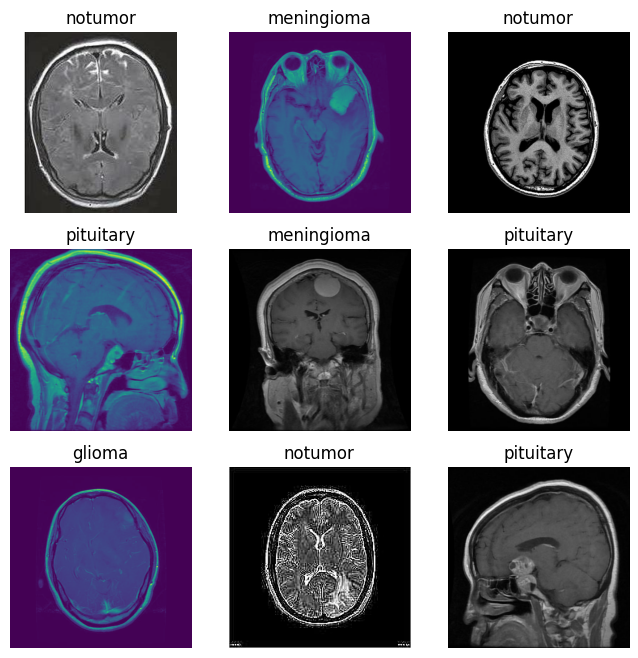

In [ ]:
import random
data_train = "/content/braintumor/Training"

fig, axes = plt.subplots(3, 3, figsize=(8,8))

for ax in axes.ravel():
    random_class = random.choice(['glioma', 'meningioma', 'notumor', 'pituitary'])
    random_img = random.choice(os.listdir(os.path.join(data_train, random_class)))
    img = Image.open(os.path.join(data_train, random_class, random_img))
    ax.imshow(img)
    ax.set_title(random_class)
    ax.axis("off")

plt.show()

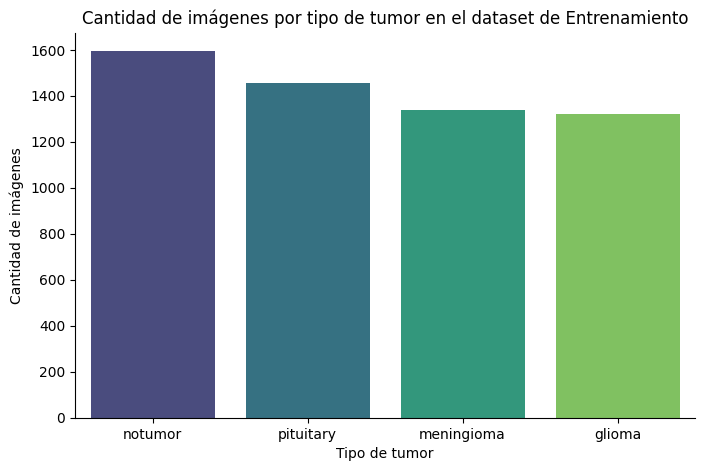

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()  # Get the current axes
plt.title("Cantidad de imágenes por tipo de tumor en el dataset de Entrenamiento")
sns.barplot(x=df_train["label"].value_counts().index, y=df_train["label"].value_counts(),palette="viridis")
plt.ylabel("Cantidad de imágenes")
plt.xlabel("Tipo de tumor")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

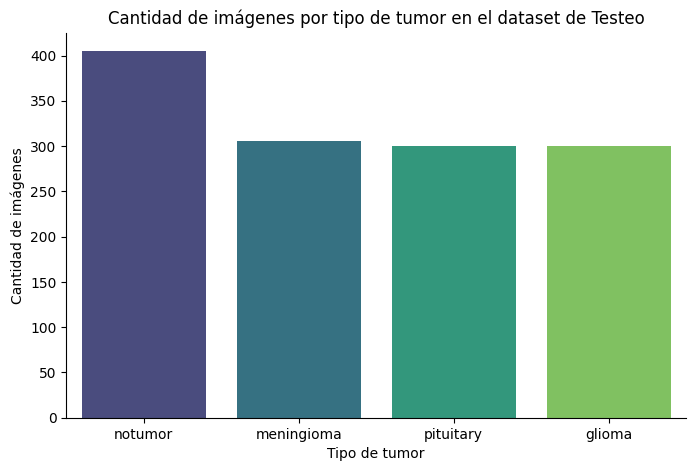

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()  # Get the current axes
plt.title("Cantidad de imágenes por tipo de tumor en el dataset de Testeo")
sns.barplot(x=df_test["label"].value_counts().index, y=df_test["label"].value_counts(),palette="viridis")
plt.ylabel("Cantidad de imágenes")
plt.xlabel("Tipo de tumor")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Separación del set de testeo en testeo y validación

In [ ]:
valid_ts, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [ ]:
tr_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ImageDataGenerator(rescale=1/255)
batchsize = 32
img_size = (224,224)

In [ ]:
gen_train = tr_gen.flow_from_dataframe(df_train, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_valid = ts_gen.flow_from_dataframe(valid_ts, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_test = ts_gen.flow_from_dataframe(df_test, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=False ,color_mode='rgb')

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
np.unique(np.array(gen_train.classes), return_counts=True)

(array([0, 1, 2, 3]), array([1321, 1339, 1595, 1457]))

In [ ]:
img_size[0],img_size[1]

(224, 224)

## Generación de la red Neuronal Convolucional

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0],img_size[1],3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [ ]:
tf.keras.metrics.F1Score()

<F1Score name=f1_score>

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.cast(K.round(y_pred), 'float32')
    y_true = K.cast(y_true, 'float32')

    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy', "recall", tf.keras.metrics.F1Score()])

In [ ]:
history = model.fit(
    gen_train,
    epochs=10,
    validation_data=gen_valid,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.6060 - f1_score: 0.5907 - loss: 0.9333 - recall: 0.4569 - val_accuracy: 0.8260 - val_f1_score: 0.7917 - val_loss: 0.4284 - val_recall: 0.7969
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 647s 4s/step - accuracy: 0.8733 - f1_score: 0.8695 - loss: 0.3603 - recall: 0.8489 - val_accuracy: 0.8824 - val_f1_score: 0.8716 - val_loss: 0.3047 - val_recall: 0.8672
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - accuracy: 0.9185 - f1_score: 0.9142 - loss: 0.2320 - recall: 0.9119 - val_accuracy: 0.9206 - val_f1_score: 0.9161 - val_loss: 0.2013 - val_recall: 0.9191
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.9344 - f1_score: 0.9328 - loss: 0.1836 - recall: 0.9302 - val_accuracy: 0.9435 - val_f1_score: 0.9409 - val_loss: 0.1610 - val_recall: 0.9420
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 641s 4s/step - accuracy: 0.9529 - f1_score: 0.9514 - loss: 0.1328 - recall: 0.9507 - val_accuracy: 0.9313 - val_f1_score: 0.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,508,430 (127.82 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,954 (85.22 MB)

In [ ]:
print(model.evaluate(gen_train))
print(model.evaluate(gen_valid))
print(model.evaluate(gen_test))

179/179 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9921 - f1_score: 0.9918 - loss: 0.0321 - recall: 0.9921
[0.03169021010398865, 0.9917716979980469, 0.9917716979980469, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.988927  , 0.9825083 , 0.99625224, 0.9979423 ], dtype=float32)>]
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9623 - f1_score: 0.9586 - loss: 0.1133 - recall: 0.9623
[0.11387021839618683, 0.9633587598800659, 0.9633587598800659, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9463087 , 0.9194631 , 0.98499995, 0.9936305 ], dtype=float32)>]
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9700 - f1_score: 0.9686 - loss: 0.0929 - recall: 0.9700
[0.1160159558057785, 0.9618902206420898, 0.9618902206420898, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9480968, 0.9196141, 0.9834515, 0.9896193], dtype=float32)>]


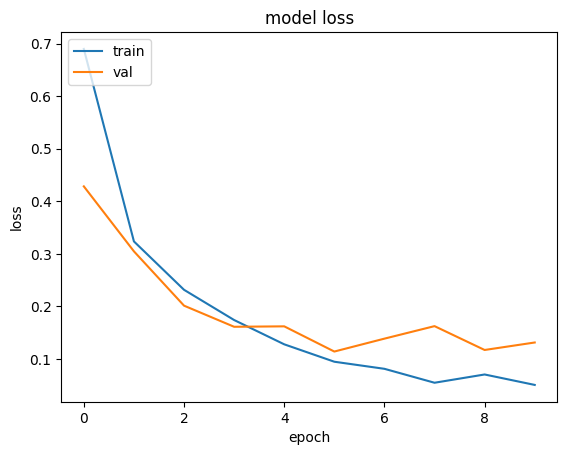

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

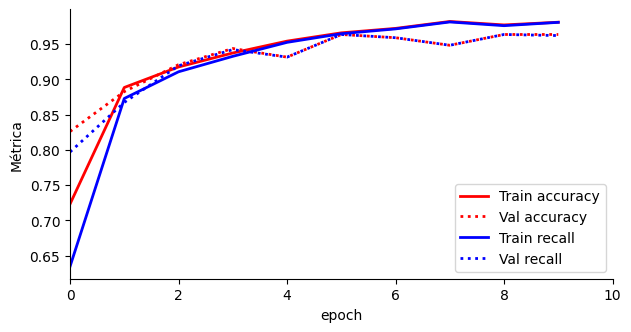

In [ ]:
fig= plt.figure(figsize=(7,3.5))
ax = plt.gca()
plt.plot(history.history['accuracy'], lw=2, c="r",label="Train accuracy")
plt.plot(history.history['val_accuracy'], lw=2, c="r",label="Val accuracy", ls=":")
plt.plot(history.history['recall'], lw=2, c="b",label="Train recall")
plt.plot(history.history['val_recall'], lw=2, c="b",label="Val recall", ls=":")
#plt.title('model loss')
plt.ylabel('Métrica')
plt.xlabel('epoch')
plt.legend()
plt.xlim(0,10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

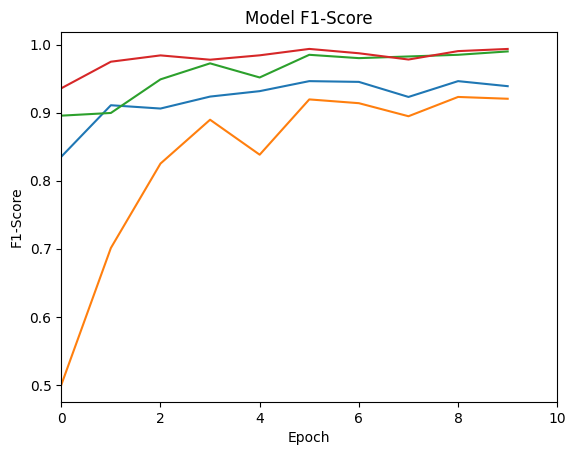

In [ ]:
plt.plot(history.history['val_f1_score'])
plt.xlim(0,10)
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
#plt.legend(['glioma' 'meningioma' 'notumor' 'pituitary'])

plt.show()

In [ ]:
print("Training generator class indices:", gen_train.class_indices)

Training generator class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Guardar el modelo

In [ ]:
model.save("Modelo_cnn_BT.keras")